In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn nltk nrclex

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devya\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\devya\AppData\Roaming\nltk_data...


Data loaded successfully. Shape: (1000, 10)
Preprocessing text...
Running NRC Sentiment Analysis (this may take a moment)...
NRC Analysis complete.
Running NMF Topic Modelling...

--- Discovered Topics ---
Topic 0: problem, explanation, quick, lab, concept, simulation, topic, practice, hint, set
Topic 1: writing, grammar, feedback, essay, prompt, style, reading, check, comprehension, helpful
Topic 2: pronunciation, practice, conversation, drill, vocabulary, cultural, language, context, feedback, great
Topic 3: source, primary, id, timeline, analysis, like, prompt, quick, historical, helpful
Topic 4: debugging, example, project, case, realworld, code, algorithm, study, coding, great

Calculating Sentiment Orientation per Topic...

--- Average Emotion Scores per Topic ---
              fear     anger  anticip     trust  surprise  positive  negative  \
Topic_ID                                                                        
0         0.073358  0.011876      0.0  0.136847  0.029023

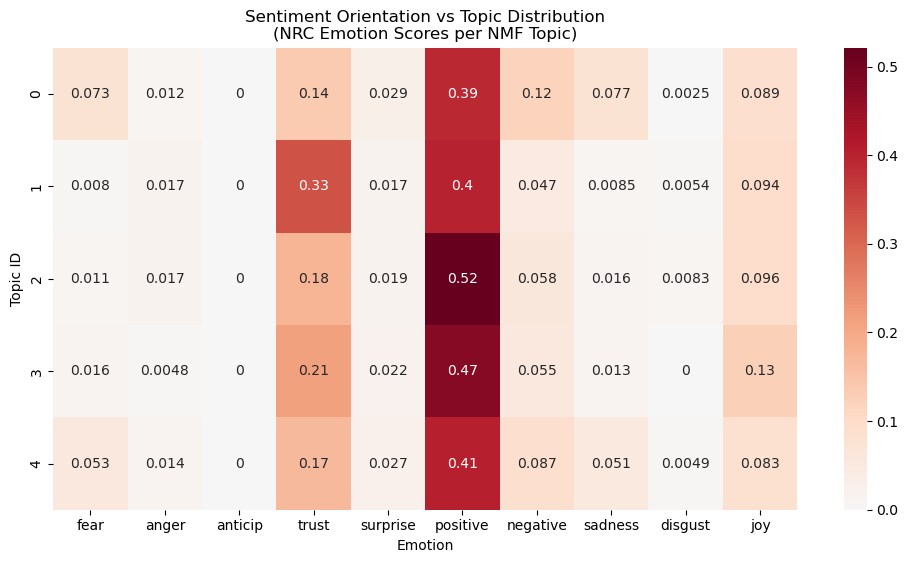


Analysis complete. Detailed file saved to: student_feedback_analyzed.csv


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nrclex import NRCLex
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ==========================================
# STEP 1: LOAD DATA & CONFIGURATION
# ==========================================

# !!! ACTION REQUIRED: Put the path to your CSV file here !!!
# Example: FILE_PATH = 'C:/Users/Name/Documents/student_feedback.csv'
FILE_PATH = r"C:\Users\devya\Downloads\student_feedback_ai_tutoring.csv\student_feedback_ai_tutoring.csv" 

# !!! ACTION REQUIRED: Enter the exact column name containing the feedback text !!!
TEXT_COLUMN = 'feedback_text' 

try:
    df = pd.read_csv(FILE_PATH)
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: File not found. Please check the FILE_PATH variable.")
    exit()

# ==========================================
# STEP 2: TEXT PREPROCESSING
# ==========================================
print("Preprocessing text...")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # 1. Lowercase
    text = text.lower()
    # 2. Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 3. Tokenize
    tokens = text.split()
    # 4. Remove stopwords and Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply cleaning
df['clean_text'] = df[TEXT_COLUMN].apply(clean_text)

# ==========================================
# STEP 3: NRC EMOTION ANALYSIS
# ==========================================
print("Running NRC Sentiment Analysis (this may take a moment)...")

def get_nrc_emotions(text):
    # Create NRCLex object
    emotion_obj = NRCLex(text)
    # Return the dictionary of affect frequencies
    return emotion_obj.affect_frequencies

# Apply NRC analysis
emotion_results = df['clean_text'].apply(get_nrc_emotions)

# Convert the list of dictionaries into a DataFrame
emotion_df = pd.json_normalize(emotion_results)

# Combine with original data
df = pd.concat([df, emotion_df], axis=1)

print("NRC Analysis complete.")

# ==========================================
# STEP 4: TOPIC MODELLING (NMF)
# ==========================================
print("Running NMF Topic Modelling...")

# 1. TF-IDF Vectorization
# NMF requires non-negative input, TF-IDF is perfect for this
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

# 2. Fit NMF Model
# You can adjust n_components (number of topics) based on your needs
NUM_TOPICS = 5 
nmf_model = NMF(n_components=NUM_TOPICS, random_state=42, init='nndsvd')
nmf_features = nmf_model.fit_transform(tfidf)

# 3. Assign Topics to Documents
# Get the topic with the highest score for each student feedback
df['Topic_ID'] = nmf_features.argmax(axis=1)

# 4. Interpret Topics (Print top words per topic)
feature_names = tfidf_vectorizer.get_feature_names_out()
topic_dict = {}

print("\n--- Discovered Topics ---")
for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_ind = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_features_ind]
    topic_label = f"Topic {topic_idx}"
    topic_dict[topic_idx] = ", ".join(top_words)
    print(f"{topic_label}: {', '.join(top_words)}")

# Map topic ID to top words for readability
df['Topic_Keywords'] = df['Topic_ID'].map(topic_dict)

# ==========================================
# STEP 5: COMBINE SENTIMENT & TOPIC DISTRIBUTION
# ==========================================
print("\nCalculating Sentiment Orientation per Topic...")

# We aggregate the emotion scores by Topic
# Emotions typically returned by NRC: fear, anger, anticip, trust, surprise, positive, negative, sadness, disgust, joy
emotions_cols = ['fear', 'anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy']

# Ensure columns exist (sometimes NRC returns fewer if text is short)
existing_emotion_cols = [col for col in emotions_cols if col in df.columns]

# Group by Topic and calculate mean emotion scores
topic_sentiment_analysis = df.groupby('Topic_ID')[existing_emotion_cols].mean()

print("\n--- Average Emotion Scores per Topic ---")
print(topic_sentiment_analysis)

# ==========================================
# STEP 6: VISUALIZATION (HEATMAP)
# ==========================================
plt.figure(figsize=(12, 6))
sns.heatmap(topic_sentiment_analysis, annot=True, cmap='RdBu_r', center=0)
plt.title('Sentiment Orientation vs Topic Distribution\n(NRC Emotion Scores per NMF Topic)')
plt.ylabel('Topic ID')
plt.xlabel('Emotion')
plt.show()

# ==========================================
# STEP 7: SAVE RESULTS
# ==========================================
output_path = 'student_feedback_analyzed.csv'
df.to_csv(output_path, index=False)
print(f"\nAnalysis complete. Detailed file saved to: {output_path}")

In [3]:
# ==========================================
# STEP 8: DRILL DOWN INTO "PROBLEM" AREAS
# ==========================================
pd.set_option('display.max_colwidth', None) # Show full text

print("--- Deep Dive: Analyzing 'Fear' in Topic 0 (Labs/Concepts) ---")

# Filter for Topic 0 where Fear score is significant (e.g., top 25% of fear scores)
fear_threshold = df['fear'].quantile(0.75)
problem_comments = df[
    (df['Topic_ID'] == 0) & 
    (df['fear'] > fear_threshold)
][['feedback_text', 'fear', 'negative']].sort_values(by='fear', ascending=False).head(10)

print(f"Top 10 most 'Fearful' comments in Topic 0:\n")
print(problem_comments)

# Let's also look at the 'Trust' driver in Topic 1
print("\n--- Deep Dive: Analyzing 'Trust' in Topic 1 (Writing) ---")
trust_comments = df[
    (df['Topic_ID'] == 1) & 
    (df['trust'] > df['trust'].mean())
][['feedback_text', 'trust']].sort_values(by='trust', ascending=False).head(5)
print(trust_comments)

--- Deep Dive: Analyzing 'Fear' in Topic 0 (Labs/Concepts) ---
Top 10 most 'Fearful' comments in Topic 0:

                                                                                                                                     feedback_text  \
618                       Very intuitive and thorough. I particularly value the worked examples and step-by-step solutions for difficult problems.   
430                                 Sometimes the math problems are too abstract. I want more real-life examples and slower pacing for new topics.   
231                   Struggled with some syntax-based hints and felt some topics were rushed. Needs clearer walkthroughs for multi-step problems.   
171                        Great explanations of reaction mechanisms and problem sets. Could use more lab-style simulations and step-by-step labs.   
776           Nice quick problem sets and lab simulations help me visualize reactions. Would like more visualizations for electron configuratio


Generating Word Clouds for each Topic...


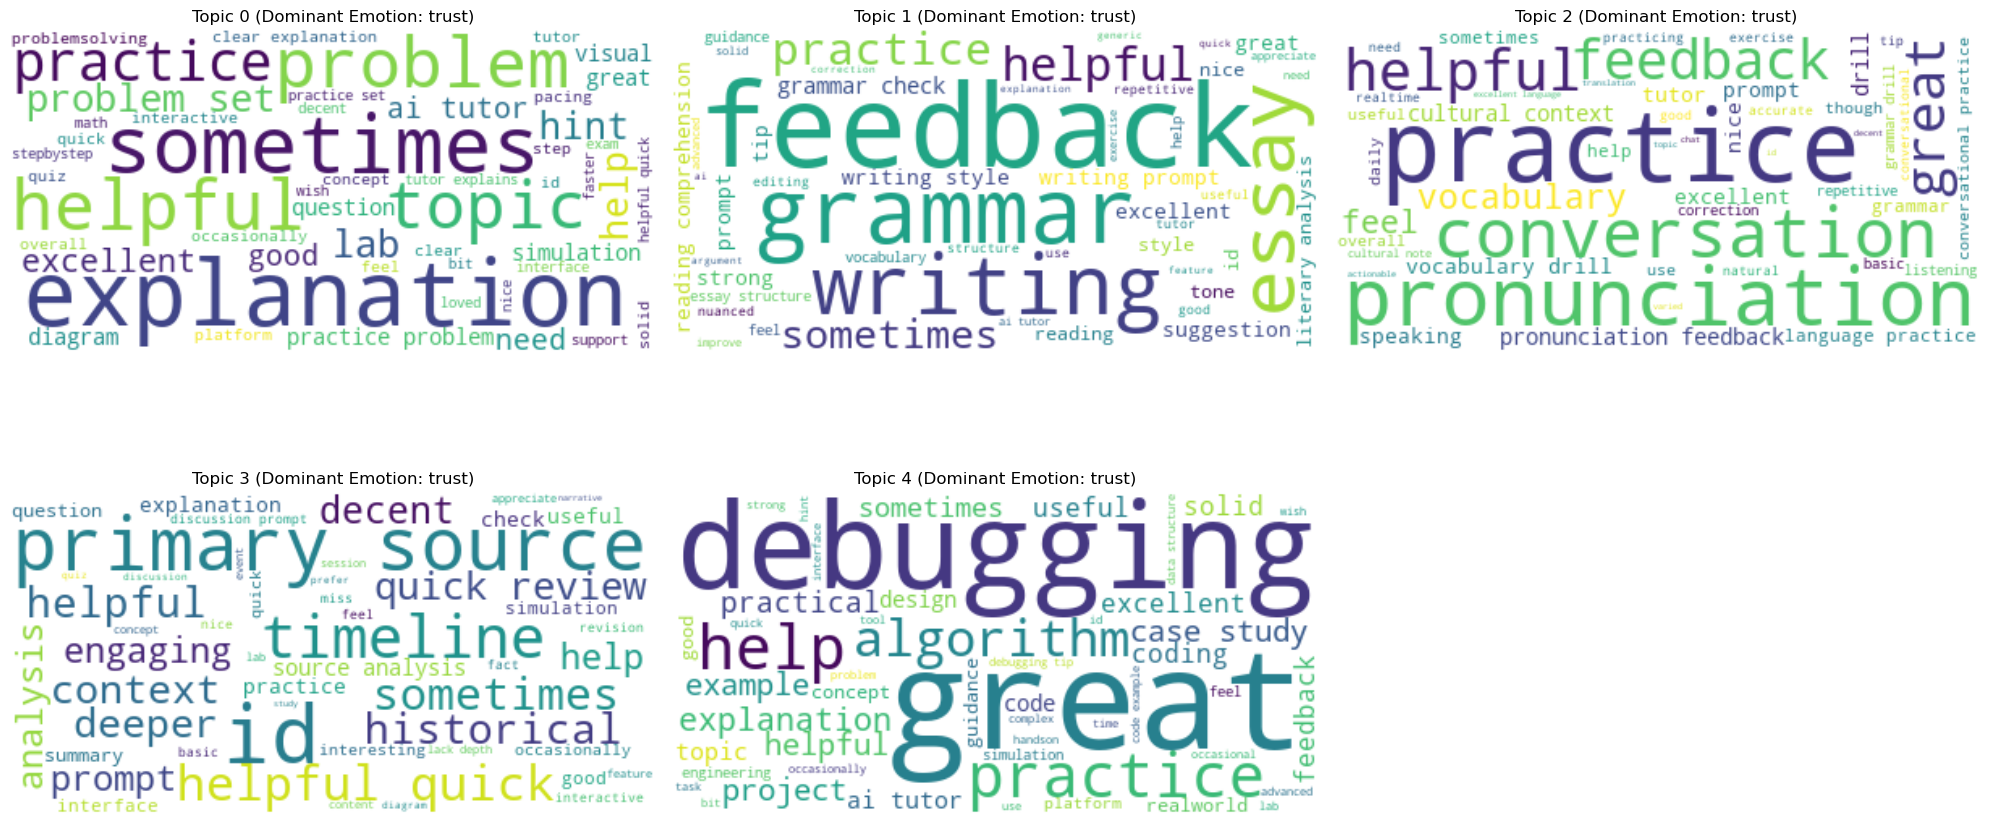

In [4]:
# ==========================================
# STEP 9: VISUALIZATION - WORD CLOUDS
# ==========================================
from wordcloud import WordCloud

print("\nGenerating Word Clouds for each Topic...")

plt.figure(figsize=(20, 10))

for i in range(5): # Since you have 5 topics (0-4)
    # Get all text belonging to this topic
    topic_text = " ".join(df[df['Topic_ID'] == i]['clean_text'])
    
    # Generate cloud
    wc = WordCloud(background_color='white', max_words=50, colormap='viridis').generate(topic_text)
    
    # Plot
    plt.subplot(2, 3, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Topic {i} (Dominant Emotion: {df[df['Topic_ID']==i][['fear','joy','trust']].mean().idxmax()})")
    plt.axis('off')

plt.tight_layout()
plt.show()


--- Correlation: Word Count vs Sentiment ---
word_count    1.000000
positive      0.004264
negative      0.050626
anger        -0.010877
trust        -0.082957
Name: word_count, dtype: float64


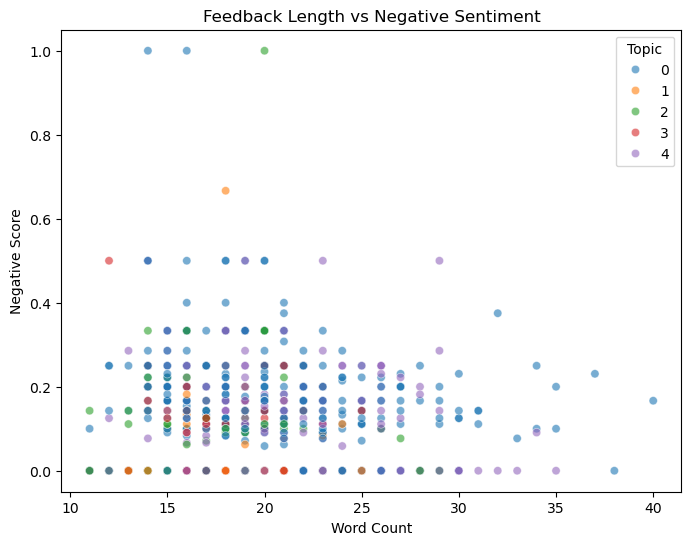

In [5]:
# ==========================================
# STEP 10: META-DATA ANALYSIS
# ==========================================

# Calculate word count
df['word_count'] = df['feedback_text'].apply(lambda x: len(str(x).split()))

# Correlation matrix between Word Count and Emotions
correlation_cols = ['word_count', 'positive', 'negative', 'anger', 'trust']
corr_matrix = df[correlation_cols].corr()

print("\n--- Correlation: Word Count vs Sentiment ---")
print(corr_matrix['word_count'])

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='word_count', y='negative', hue='Topic_ID', palette='tab10', alpha=0.6)
plt.title('Feedback Length vs Negative Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Negative Score')
plt.legend(title='Topic')
plt.show()

Preparing data for Student Segmentation...
Running K-Means Clustering...

--- Student Persona Profiles ---
Student_Persona_Cluster         0         1         2
fear                     0.008096  0.138009  0.006835
anger                    0.000977  0.031346  0.013086
trust                    0.202655  0.083538  0.266008
joy                      0.119729  0.046438  0.096722
negative                 0.034360  0.211979  0.036889
positive                 0.496093  0.264732  0.474486
Topic_0_Weight           0.040485  0.069620  0.006098
Topic_1_Weight           0.006958  0.006845  0.111403
Topic_2_Weight           0.009770  0.008405  0.106994
Topic_3_Weight           0.039720  0.015160  0.015231
Topic_4_Weight           0.052418  0.035751  0.009106

Visualizing Segments with PCA...


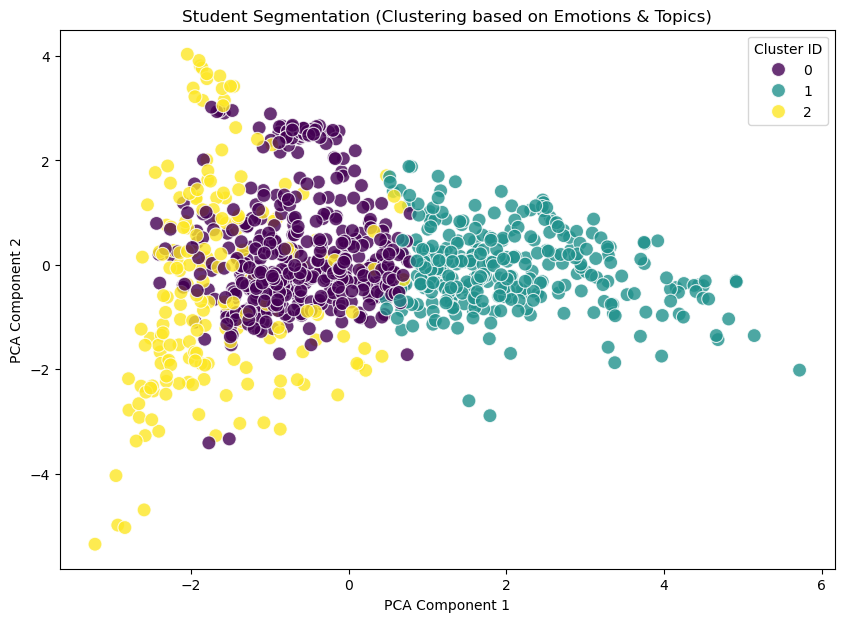


Exported 314 students in the 'At Risk' group to at_risk_students_list.csv


In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ==========================================
# STEP 11: PREPARE DATA FOR SEGMENTATION
# ==========================================
print("Preparing data for Student Segmentation...")

# 1. Get the Topic Weights (The strength of each topic for each student)
# We need the raw NMF scores we calculated earlier (nmf_features)
# If nmf_features is lost from memory, we re-transform:
# nmf_features = nmf_model.transform(tfidf) 
topic_cols = [f'Topic_{i}_Weight' for i in range(nmf_features.shape[1])]
topic_weight_df = pd.DataFrame(nmf_features, columns=topic_cols)

# 2. Select Emotion Columns
emotion_cols = ['fear', 'anger', 'trust', 'joy', 'negative', 'positive']
# Ensure we only use emotions that actually exist in your data
valid_emotion_cols = [col for col in emotion_cols if col in df.columns]

# 3. Combine Topic Weights and Emotions
segmentation_data = pd.concat([df[valid_emotion_cols], topic_weight_df], axis=1)

# 4. Normalize the data (Clustering requires scaling)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(segmentation_data)

# ==========================================
# STEP 12: K-MEANS CLUSTERING
# ==========================================
print("Running K-Means Clustering...")

# We will create 3 segments (You can change n_clusters to 4 or 5 if needed)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels to original dataframe
df['Student_Persona_Cluster'] = clusters

# ==========================================
# STEP 13: ANALYZE THE PERSONAS
# ==========================================
print("\n--- Student Persona Profiles ---")

# Group by Cluster and calculate the mean of Emotions and Topic Weights
# We join the topic weights back to df for this calculation
df_analysis = pd.concat([df, topic_weight_df], axis=1)

# Calculate means for numeric columns only
numeric_cols = valid_emotion_cols + topic_cols
persona_profile = df_analysis.groupby('Student_Persona_Cluster')[numeric_cols].mean()

print(persona_profile.T) # Transpose for easier reading

# ==========================================
# STEP 14: VISUALIZATION (PCA)
# ==========================================
print("\nVisualizing Segments with PCA...")

# Reduce dimensions to 2D so we can plot it
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=principal_components[:, 0], 
    y=principal_components[:, 1], 
    hue=df['Student_Persona_Cluster'], 
    palette='viridis', 
    s=100,
    alpha=0.8
)
plt.title('Student Segmentation (Clustering based on Emotions & Topics)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster ID')
plt.show()

# ==========================================
# STEP 15: EXPORT "AT RISK" LIST
# ==========================================
# Identify the cluster with the highest 'negative' or 'fear' score
risk_cluster = persona_profile['fear'].idxmax()
print(f"\nWARNING: Cluster {risk_cluster} appears to be the 'At Risk' group (Highest Fear).")

# Save just these students for the support team
at_risk_students = df[df['Student_Persona_Cluster'] == risk_cluster]
at_risk_path = 'at_risk_students_list.csv'
at_risk_students.to_csv(at_risk_path, index=False)

print(f"Exported {len(at_risk_students)} students in the 'At Risk' group to {at_risk_path}")

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# STEP 16: DEFINE TARGET & SPLIT DATA
# ==========================================
print("Building Predictive Triage Model...")

# We define our target: Is this student in the 'Risk Cluster'?
# (Assuming 'risk_cluster' variable holds the ID from the previous step. 
# If not, replace 'risk_cluster' with the specific number, e.g., 0, 1, or 2)
try:
    # Create a binary target: 1 if At Risk, 0 if not
    df['is_urgent'] = df['Student_Persona_Cluster'].apply(lambda x: 1 if x == risk_cluster else 0)
    print(f"Target defined based on Risk Cluster {risk_cluster}.")
except NameError:
    # Fallback if risk_cluster isn't in memory: Use the cluster with highest Fear
    risk_cluster = persona_profile['fear'].idxmax()
    df['is_urgent'] = df['Student_Persona_Cluster'].apply(lambda x: 1 if x == risk_cluster else 0)
    print(f"Target defined based on Risk Cluster {risk_cluster} (calculated dynamically).")

X = df['clean_text']
y = df['is_urgent']

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==========================================
# STEP 17: TRAIN CLASSIFIER PIPELINE
# ==========================================
print("Training Random Forest Classifier...")

# We create a pipeline that does Vectorization -> Classification automatically
# Note: We use a fresh TF-IDF here to ensure the model is self-contained
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

# ==========================================
# STEP 18: EVALUATE MODEL PERFORMANCE
# ==========================================
print("\n--- Model Performance Evaluation ---")
predictions = pipeline.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['Normal', 'Urgent/At Risk']))

# ==========================================
# STEP 19: REAL-TIME PREDICTION FUNCTION
# ==========================================
# This is the tool you give to the engineering team
def predict_priority(new_text):
    # Clean the input using the function we defined in Step 2
    cleaned = clean_text(new_text)
    # Predict
    prediction = pipeline.predict([cleaned])[0]
    # Get probability (confidence)
    proba = pipeline.predict_proba([cleaned])[0][1]
    
    status = "URGENT / AT RISK" if prediction == 1 else "Normal"
    return status, f"{proba:.2%}"

print("\n--- Testing the Model on New/Fake Data ---")

# Test Case 1: Simulating a happy student
test_1 = "I really loved the essay writing tool, it helped me improve my grammar significantly."
status_1, conf_1 = predict_priority(test_1)
print(f"Feedback: '{test_1}'\n -> Prediction: {status_1} (Confidence: {conf_1})\n")

# Test Case 2: Simulating a frustrated student (similar to Topic 0)
test_2 = "The lab simulation keeps crashing and I don't understand the error message. It's very frustrating."
status_2, conf_2 = predict_priority(test_2)
print(f"Feedback: '{test_2}'\n -> Prediction: {status_2} (Confidence: {conf_2})\n")

# ==========================================
# STEP 20: SAVE THE MODEL
# ==========================================
import joblib

model_filename = 'student_feedback_triage_model.pkl'
joblib.dump(pipeline, model_filename)
print(f"Model saved to {model_filename}. You can now use this in production.")

Building Predictive Triage Model...
Target defined based on Risk Cluster 1.
Training Random Forest Classifier...

--- Model Performance Evaluation ---
Confusion Matrix:
[[135   2]
 [ 19  44]]

Classification Report:
                precision    recall  f1-score   support

        Normal       0.88      0.99      0.93       137
Urgent/At Risk       0.96      0.70      0.81        63

      accuracy                           0.90       200
     macro avg       0.92      0.84      0.87       200
  weighted avg       0.90      0.90      0.89       200


--- Testing the Model on New/Fake Data ---
Feedback: 'I really loved the essay writing tool, it helped me improve my grammar significantly.'
 -> Prediction: Normal (Confidence: 10.00%)

Feedback: 'The lab simulation keeps crashing and I don't understand the error message. It's very frustrating.'
 -> Prediction: Normal (Confidence: 30.00%)

Model saved to student_feedback_triage_model.pkl. You can now use this in production.


In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

print("--- STARTING MASTER FIX ---")

# 1. ENSURE NMF FEATURES EXIST
# We need to recreate the topic weights to perform clustering
print("1. Regenerating Topic Weights...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

# Re-run NMF (assuming 5 topics as before)
nmf_model = NMF(n_components=5, random_state=42, init='nndsvd')
nmf_features = nmf_model.fit_transform(tfidf)

# 2. RE-RUN CLUSTERING (Step 11 & 12 Logic)
print("2. Re-running Student Segmentation (Clustering)...")
topic_cols = [f'Topic_{i}_Weight' for i in range(nmf_features.shape[1])]
topic_weight_df = pd.DataFrame(nmf_features, columns=topic_cols)

# Select Emotion Columns
emotion_cols = ['fear', 'anger', 'trust', 'joy', 'negative', 'positive']
valid_emotion_cols = [col for col in emotion_cols if col in df.columns]

# Combine & Scale
segmentation_data = pd.concat([df[valid_emotion_cols], topic_weight_df], axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(segmentation_data)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Student_Persona_Cluster'] = kmeans.fit_predict(scaled_features)
print("   -> 'Student_Persona_Cluster' column created successfully.")

# 3. DEFINE 'IS_URGENT' (Risk Logic)
print("3. Identifying 'At Risk' Students...")
# Find cluster with highest Fear
cluster_stats = df.groupby('Student_Persona_Cluster')[['fear']].mean()
risk_cluster_id = cluster_stats['fear'].idxmax()
df['is_urgent'] = df['Student_Persona_Cluster'].apply(lambda x: 1 if x == risk_cluster_id else 0)
print(f"   -> Cluster {risk_cluster_id} identified as High Risk.")

# 4. GENERATE EXECUTIVE SUMMARY
print("4. Generating Executive Summary...")

# Recalculate Topic Keywords for the report
feature_names = tfidf_vectorizer.get_feature_names_out()
topic_dict = {}
for topic_idx, topic in enumerate(nmf_model.components_):
    top_features_ind = topic.argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_features_ind]
    topic_dict[topic_idx] = ", ".join(top_words)

# Calculate Stats
total_students = len(df)
at_risk_count = df['is_urgent'].sum()
at_risk_pct = (at_risk_count / total_students) * 100

# Get N-Grams for Risk Group
risk_text = df[df['is_urgent'] == 1]['clean_text']
def get_top_ngrams(corpus, n=2, top_k=3):
    if len(corpus) < 1: return []
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

top_bigrams = get_top_ngrams(risk_text, n=2, top_k=3)
phrase_1 = top_bigrams[0][0] if len(top_bigrams) > 0 else "None detected"
phrase_2 = top_bigrams[1][0] if len(top_bigrams) > 1 else ""

# Identify Key Topics
# We need to group by Topic_ID (ensure it exists)
df['Topic_ID'] = nmf_features.argmax(axis=1)
topic_sentiment = df.groupby('Topic_ID')[valid_emotion_cols].mean()

fearful_topic_idx = topic_sentiment['fear'].idxmax()
trusted_topic_idx = topic_sentiment['trust'].idxmax()

summary_text = f"""
EXECUTIVE SUMMARY: AI TUTORING PLATFORM FEEDBACK ANALYSIS
=========================================================
Total Students Analyzed: {total_students}

1. RISK ASSESSMENT
------------------
- {at_risk_count} students ({at_risk_pct:.1f}%) are classified as "At Risk" / High Priority.
- Primary Pain Point (Highest Fear): Topic {fearful_topic_idx}
  Keywords: {topic_dict[fearful_topic_idx]}

2. PLATFORM STRENGTHS
---------------------
- Most Trusted Feature: Topic {trusted_topic_idx}
  Keywords: {topic_dict[trusted_topic_idx]}

3. ACTIONABLE PHRASES (FROM RISK GROUP)
---------------------------------------
- {phrase_1}
- {phrase_2}

Report Generated Automatically.
"""

with open('Executive_Summary.txt', 'w') as f:
    f.write(summary_text)

print("\nSUCCESS: 'Executive_Summary.txt' has been created.")

--- STARTING MASTER FIX ---
1. Regenerating Topic Weights...


KeyError: 'clean_text'